# Obama's Briefing Topic Analysis


The goal of the project is to discover the abstract topics that occur in a  collection of Obama briefings to check which topic Obama mentioned the most. 



In [2]:
import string;
import nltk
import json
import ast
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import collections


from collections import defaultdict
from boltons.jsonutils import JSONLIterator
from boltons.dictutils import OMD
from lxml.html import soupparser
from lxml.cssselect import CSSSelector

from gensim.models.coherencemodel import CoherenceModel

## Data

Obama’s briefings were found in the whitehouse webpage. We use the data file at github, which is the download from whitehouse homepage, “ https://www.whitehouse.gov/briefings-statements/ ”. The data file can be found at “ https://github.com/mahmoud/briefings “ 
Briefings.jsonl : 1778 Obama’s briefings from 2009 to 2016. 


In [3]:
# the path of file 

BRIEFINGS_FILE = '/Users/kim.jiy/documents/springboard/topic/data/briefings/briefings.jsonl'


In [4]:
import string;
import nltk
import json
import ast
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

stemmer = SnowballStemmer("english")


## Data Cleaning and Preparation

Punctuation : punctuation such as “a”, “!” , “?”, ets were removed at each contents of briefings using “string.punctuation” provided from Python

Unicode implementation: To have words encoded using Unicode encoding, I encoded text type to  utf-8 and remove any numbers and also change 
every words to lower cases.  

tokenization : Tokenized every words in contents


In [28]:
# Data Cleaning. From the briefing file , meaningless words are removed and each words are tokenized. 

def makeInputDate(briefing_text):
    
    # "exclude" contains set of punctuation
    exclude = set(string.punctuation)
    s = briefing_text
    
    # remove punctuation from breifing using "exclude" 
    s = ''.join(ch for ch in s if ch not in exclude)
    
    
    # encode text type to  utf-8 and remove any numbers. also change every words to lower case. 
    s1 = str(s.encode('utf-8')).translate(None, '0123456789').lower()
    
    # store tokenize words to "tokens"
    tokens = nltk.word_tokenize(s1)

    # stopwords are commonly used words such as "a", "the", "an"
    stop_words = set(stopwords.words('english'))
    
    # "additional_stop_words" is the set of meaningless words which are added from the result of the model. 
    additional_stop_words = ['presid','mr','say','think','go','well','get','q','said','veri'
                 , 'jame', 'bradi','press','brief','room','pm','est','go','got'
                 , 'ive','g','weve', 'one', 'dont', 'doe', 'de', 'hes','would'
                 ,'ani','also', 'gibb','earnest','carney','robert']

    # add additional stop words to "stop_words"
    stop_words.update(additional_stop_words)

    # store result to "output"
    output = []
    
    # To count how many meaningful words in a Briefing
    num_meaning = len(tokens)
    # To count how many meaningless words in a Briefing
    num_meaningless= 0
    
    for token in tokens:
        

        # remove morphological affixes
        try:
            stemms = stemmer.stem(token);

        except UnicodeDecodeError:
            stemms = "UnicodeDecodeError";

        i = 0;
        
        
        
        # check if word is in the set of meaningless words, "stop_words". 

        try:
            if stemms in stop_words:
                i += 1
                num_meaningless +=1;
            elif stemms in additional_stop_words:
                i += 1
                num_meaningless +=1;

        except UnicodeDecodeError:
                i += 1
                num_meaningless +=1;

        # if word is not in the set of meaningless words, the word is kept in the result        
        try:
            if i == 0 and stemms != "UnicodeDecodeError":
                output.append(str(stemms.encode('utf8')))
        except UnicodeDecodeError:
            i += 1




    return output, num_meaningless , num_meaning;

Gather the list of tokenized words to "description"

In [29]:
from datetime import datetime

jsonl_iter = JSONLIterator(open(BRIEFINGS_FILE))

stemmer = SnowballStemmer("english")

res = defaultdict(list)

# count how many numbers of words in every breifing
nums = 0;

#To store tokenized words in each briefing 
descriptions = []

# To store date of each breifing
topic_year = []

num_mean = []
num_meanless= []

for obj in jsonl_iter:

    title = obj['title']
    briefing_html = obj['content']
    date = obj['date']
    date_year = date[-4:]
    
    #convert string to datetime
    d_format = datetime.strptime(date, '%B %d, %Y')
    month = d_format.month
    
    # have year and month of date for each briefing
    cur_date = str(date_year)+ "-" + str(d_format.month)
    
     # parse html
    content_tree = soupparser.fromstring(briefing_html)
    pane_tree = content_tree.cssselect('.pane-node-field-forall-body')
    briefing_text = pane_tree[0].text_content()
    
    # store tonkenized meaningful words for each briefing to "descriptions"
    descriptions.append(makeInputDate(briefing_text)[0])
    
    num_meanless.append(makeInputDate(briefing_text)[1])
    num_mean.append(makeInputDate(briefing_text)[2])
    
    # store date of each breifing to "topic_year"
    topic_year.append(cur_date)
    nums += 1;



There are 1778 breifings in total

In [7]:
# Let's check how many brefings in total.

print(nums)

1778


## Data Storytelling

Let's check how many words in each briefings. 

From two bar plots above, we can see that graphs look alike. After removing punctuation, about 50 % was removed.     

In [30]:
# the number of words before removing punctuation 

print( np.mean(num_mean), np.amin(num_mean), np.amax(num_mean))

(7016.9325084364455, 101, 24271)


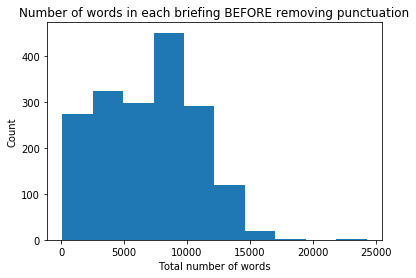

In [31]:
# Draw histogram about number of words in each briefing BEFORE emoving punctuation

plt.hist(num_mean)
plt.title("Number of words in each briefing BEFORE removing punctuation")
plt.xlabel("Total number of words")
plt.ylabel("Count")
plt.show()

In [32]:
# # the number of words after removing punctuation

words = np.subtract(num_mean,num_meanless)
print( np.mean(words), np.amin(words), np.amax(words))

(3205.498875140607, 62, 10929)


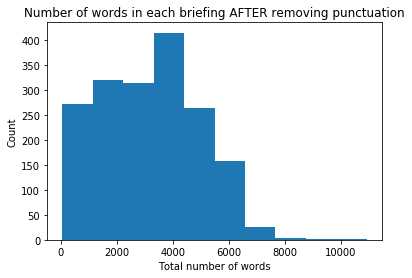

In [33]:
# Draw histogram about number of words in each briefing AFTER emoving punctuation

plt.hist(words)
plt.title("Number of words in each briefing AFTER removing punctuation")
plt.xlabel("Total number of words")
plt.ylabel("Count")
plt.show()

In [34]:
# check the unique words and frequency of each unique words

uniq_nums = []

for desc in descriptions:
    for word in desc:
        uniq_nums.append(word)

ctr = collections.Counter(uniq_nums)

## Machine Learning


First, I constructed a mapping table to efficeintly use values to models. Then, it was converted into a bag-of-words. As a result, we have frequency table of each words. 


In [9]:
from gensim import corpora, models, similarities
import logging, gensim, bz2


# Construct ID mapping table to  map tokens to IDs 
dictionary = corpora.Dictionary(descriptions)
type(dictionary.token2id)

## converts dictionary into a bag-of-words. 
raw_corpus2 = [dictionary.doc2bow(t) for t in descriptions]



### LDA

This is one the most popular topic modeling algorithms today. It is a generative model in that it assumes each document is a mixture of topics and in turn, each topic is a mixture of words. So LDA groups words into topics. Then it compares to two topics and determine which topic is close. 

### Parameter tuning for LDA

LDA require a num_topics parameter (set to 200 by default) to determine the number of latent dimensions after the SVD. So several numbers of topics were tested on the model to pick the best one. Coherence socre was used to measure the model. Topic coherence measures the human interpretability of a topic model. Topic coherence evaluates topic models how models are interpretable using wikipedia or wordnet. Thus this can be used to compare different topic models. 

In [10]:
# number of topics were tried to find the optimal number of topics

num_topic = [12, 15, 17, 19 , 21, 23, 35]
cohere_list = []
for i in num_topic:
    cur_lda = gensim.models.ldamodel.LdaModel(corpus=raw_corpus2, id2word=dictionary, num_topics=i, update_every=1, chunksize=50, passes=1)
    cm = CoherenceModel(model=cur_lda, texts=descriptions, dictionary=dictionary, coherence='c_v')
    cohere_list.append(cm.get_coherence())

cohere_list

[0.32689221476002644,
 0.36255912995590456,
 0.3133447054959873,
 0.3361751587638444,
 0.3513167502597674,
 0.382638897636696,
 0.41941253540173123]

The best model was with the number of topics of 23 from the graph below. 

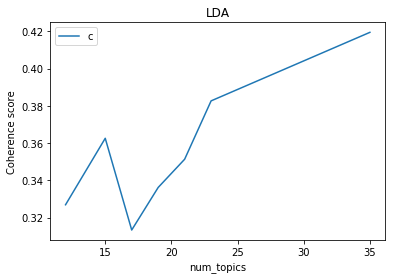

In [11]:
plt.plot(num_topic, cohere_list)
plt.title("LDA")
plt.xlabel("num_topics")
plt.ylabel("Coherence score")
plt.legend(("c_v"), loc='best')
plt.show()

In [12]:
# The optimal model is the one with 23 topics
lda = gensim.models.ldamodel.LdaModel(corpus=raw_corpus2, id2word=dictionary, num_topics=23, update_every=1, chunksize=50, passes=1)




## Visualization

Let's visualize the result.

The dominants of each topic can be visualized like below. Topics with the bigger circle mean the more importance relative to the data. From the graph below, we can see that there are two clusters. Clusters on a graph mean the similarity between topics. 

The length of red bars for each words means the estimated term frequency within the topic.

In [13]:
import pyLDAvis.gensim

followers_data =  pyLDAvis.gensim.prepare(lda, raw_corpus2, dictionary)
pyLDAvis.display(followers_data)

  

/usr/local/lib/python2.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


The result of LDA with 23 topics is like below. 



In [14]:
# print 23 topics, what words consist each briefing. 
lda.print_topics(23)

[(0,
  u'0.018*"auto" + 0.017*"oil" + 0.012*"energi" + 0.010*"compani" + 0.010*"car" + 0.009*"industri" + 0.009*"administr" + 0.007*"peopl" + 0.007*"tarp" + 0.007*"talk"'),
 (1,
  u'0.013*"tax" + 0.011*"job" + 0.009*"budget" + 0.009*"economi" + 0.009*"cut" + 0.008*"peopl" + 0.008*"econom" + 0.007*"make" + 0.007*"year" + 0.006*"thing"'),
 (2,
  u'0.020*"secretari" + 0.016*"email" + 0.015*"document" + 0.013*"depart" + 0.011*"inform" + 0.011*"napolitano" + 0.009*"administr" + 0.008*"leak" + 0.006*"know" + 0.006*"account"'),
 (3,
  u'0.014*"govern" + 0.013*"peopl" + 0.012*"cuba" + 0.012*"cuban" + 0.008*"administr" + 0.007*"state" + 0.006*"american" + 0.006*"chang" + 0.006*"polici" + 0.006*"make"'),
 (4,
  u'0.015*"senat" + 0.014*"hous" + 0.012*"republican" + 0.010*"talk" + 0.008*"way" + 0.008*"know" + 0.007*"like" + 0.007*"vote" + 0.007*"want" + 0.007*"thing"'),
 (5,
  u'0.015*"iraq" + 0.015*"forc" + 0.012*"militari" + 0.011*"secur" + 0.011*"troop" + 0.007*"govern" + 0.007*"us" + 0.006*"ta

We can check on how probability of term frequency within each topic change by month and year. Also what's the top topic each year. 

Let's build dataframe which shows top topic and date for each month

In [15]:
import pandas as pd

# find the top topic for each briefing 
top_topic = [sorted(lda.get_document_topics(i), key=lambda x: -x[1])[0][0] for i in raw_corpus2]


d = {'Y': topic_year, 'topic': top_topic}

# create dataframe which consist of date and top topic for each briefing
df = pd.DataFrame(data=d)

# group each topic by month
grouped_df  = df.groupby(['Y', 'topic']).size().reset_index(name='counts')

# find how many times each top topic mentioned each month
max_cnt = grouped_df.groupby(['Y'], sort=False)['counts'].max().reset_index(name='counts')

# merge two table which are date, topic and frequency of each topic mentioned each month
final = pd.merge(grouped_df, max_cnt, on=['Y','counts'])

In [35]:
final.head()

,Y,topic,counts
0,2009-1,4,3
1,2009-10,13,9
2,2009-11,15,5
3,2009-12,17,3
4,2009-2,17,11


From the table above, Let's build the dataframe which consists of topic and date by year

In [17]:
## find the top topics which are most frequently mentioned each year
year_2009_output = []
year_2010_output = []
year_2011_output = []
year_2012_output = []
year_2013_output = []
year_2014_output = []
year_2015_output = []
year_2016_output = []
year_2017_output = []

# sort out top topics each year, from the dataframe top_topic which consist of date, topic and frequecy grouped by month. 
for i in range(0, len(topic_year)):
    
    if topic_year[i][:4] == "2009" :
        year_2009_output.append(top_topic[i] )
    elif topic_year[i][:4] == "2010" :
        year_2010_output.append(top_topic[i] )
    elif topic_year[i][:4] == "2011" :
        year_2011_output.append(top_topic[i] )
    elif topic_year[i][:4] == "2012" :
        year_2012_output.append(top_topic[i])
    elif topic_year[i][:4] == "2013" :
        year_2013_output.append(top_topic[i])
    elif topic_year[i][:4] == "2014" :
        year_2014_output.append(top_topic[i])
    elif topic_year[i][:4] == "2015" :
        year_2015_output.append(top_topic[i])
    elif topic_year[i][:4] == "2016" :
        year_2016_output.append(top_topic[i])
    elif topic_year[i][:4] == "2017" :
        year_2017_output.append(top_topic[i])

from collections import Counter

print "2009: " + str(Counter(year_2009_output))
print "2010: " + str(Counter(year_2010_output))
print "2011: " + str(Counter(year_2011_output))
print "2012: " + str(Counter(year_2012_output))
print "2013: " + str(Counter(year_2013_output))
print "2014: " + str(Counter(year_2014_output))
print "2015: " + str(Counter(year_2015_output))
print "2016: " + str(Counter(year_2016_output))
print "2017: " + str(Counter(year_2017_output))


2009: Counter({17: 80, 15: 48, 13: 46, 1: 28, 22: 16, 8: 11, 4: 7, 5: 3, 12: 3, 19: 3, 0: 2, 3: 2, 6: 2, 11: 2, 18: 2, 9: 1, 14: 1, 16: 1})
2010: Counter({13: 65, 17: 30, 4: 27, 15: 24, 1: 18, 8: 12, 0: 6, 19: 6, 22: 6, 11: 4, 5: 3, 6: 2, 9: 1, 14: 1})
2011: Counter({1: 75, 15: 35, 4: 32, 13: 31, 5: 22, 8: 10, 11: 7, 6: 3, 0: 2, 17: 2, 18: 2, 19: 2, 20: 2, 22: 2, 9: 1, 21: 1})
2012: Counter({13: 86, 1: 67, 15: 23, 8: 12, 0: 7, 4: 6, 6: 5, 12: 5, 22: 5, 17: 4, 2: 3, 5: 2, 21: 2, 19: 1})
2013: Counter({1: 46, 17: 35, 4: 29, 15: 25, 6: 22, 13: 19, 8: 5, 12: 5, 21: 4, 22: 3, 2: 2, 5: 2, 0: 1, 9: 1, 11: 1, 16: 1, 18: 1, 20: 1})
2014: Counter({9: 39, 5: 34, 13: 28, 4: 21, 1: 17, 15: 17, 19: 16, 6: 11, 17: 11, 8: 8, 18: 4, 11: 3, 12: 3, 21: 3, 3: 2, 2: 1, 22: 1})
2015: Counter({4: 37, 12: 31, 13: 31, 5: 24, 15: 22, 6: 16, 9: 7, 21: 7, 11: 6, 1: 4, 2: 4, 8: 4, 18: 4, 3: 2, 17: 2, 22: 2, 14: 1, 16: 1, 19: 1})
2016: Counter({15: 47, 22: 32, 4: 30, 13: 26, 5: 18, 6: 18, 19: 9, 21: 8, 1: 7, 12: 5,

Let's check how each topic changes by time

In [18]:
# the function to find the portion , frequence, average of probability for each topic, "topic_id"

def picks(topic_id, raw_corpus, list_date, lda_model):
    output = {}
    
    for i in range(0,len(raw_corpus)):
        # find the list of words for a specific topic which is "topic_id"
        list_topics= lda_model.get_document_topics(raw_corpus[i])
        
        # for the word which is in the set of list_topics, check whether it exists . 
        for j in list_topics:
            if j[0] == topic_id:
                if list_date[i] in output:
                    output[list_date[i]] = [output[list_date[i]][0]  + 1, output[list_date[i]][1] + j[1]]
                else:
                    output[list_date[i]] = [1,j[1]]
                break
    
    for i in output.keys():
       total_cnt = list_date.count(i) 
       output[i] = [output[i][0], output[i][0]*1.0/total_cnt, output[i][1]/output[i][0]] 
    return output

Let's draw a graph to show how the occupancy of the first top topic changes each month.  

In [19]:
topic_1 =  picks(22, raw_corpus2, topic_year, lda)

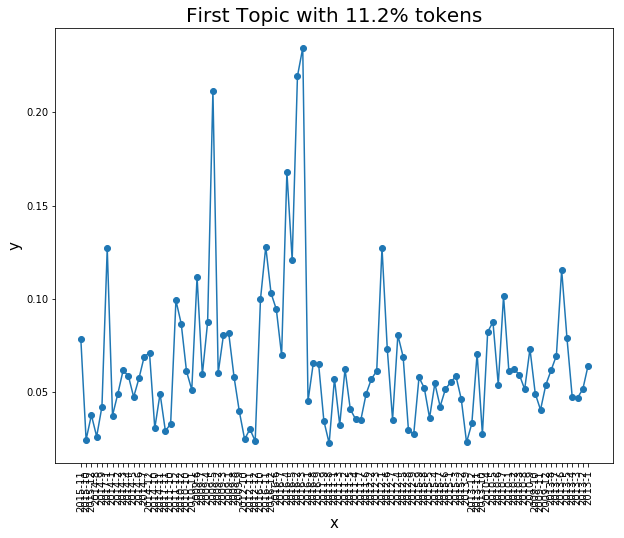

In [20]:


%matplotlib inline
import random
import sys
import array
import matplotlib.pyplot as plt


# repackage data into array-like 
graph_1 = {"x":[], "y":[], }
for label, coord in topic_1.items():
    graph_1["y"].append(coord[2])
    graph_1["x"].append(label)

# display scatter plot data
plt.figure(figsize=(10,8))
plt.title('First Topic with 11.2% tokens', fontsize=20)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.xticks(rotation=90)
plt.plot(graph_1["x"], graph_1["y"], marker = 'o')



Let's check how the occupancy of the second top topic changes each month.  

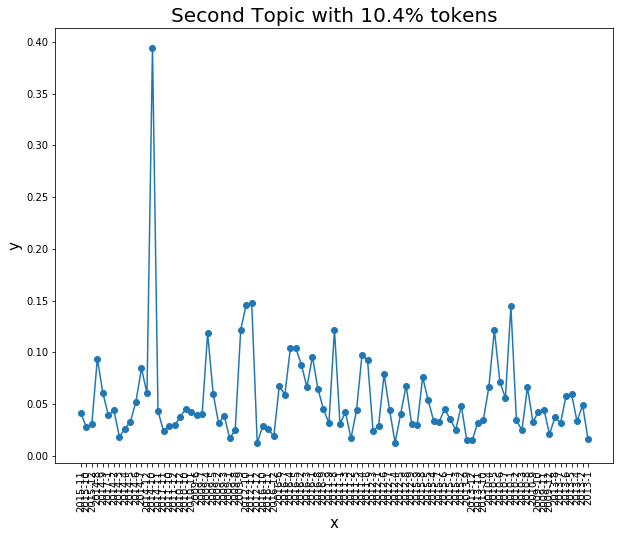

In [21]:
topic_2 =  picks(19, raw_corpus2, topic_year, lda)

graph_2 = {"x":[], "y":[], }
for label, coord in topic_2.items():
    graph_2["y"].append(coord[2])
    graph_2["x"].append(label)

# display  plot data
plt.figure(figsize=(10,8))
plt.title('Second Topic with 10.4% tokens', fontsize=20)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.xticks(rotation=90)
plt.plot(graph_2["x"], graph_2["y"], marker = 'o')



Let's check how the occupancy of the third top topic changes each month.  

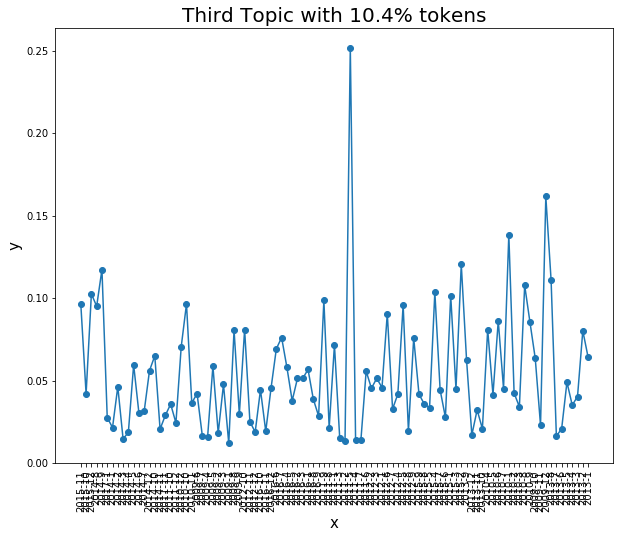

In [22]:
topic_3 =  picks(11, raw_corpus2, topic_year, lda)

graph_3 = {"x":[], "y":[], }
for label, coord in topic_3.items():
    graph_3["y"].append(coord[2])
    graph_3["x"].append(label)

# display  plot data
plt.figure(figsize=(10,8))
plt.title('Third Topic with 10.4% tokens', fontsize=20)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.xticks(rotation=90)
plt.plot(graph_3["x"], graph_3["y"], marker = 'o')




Let's draw all 3 topics on the same graph. 

/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:3363: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)


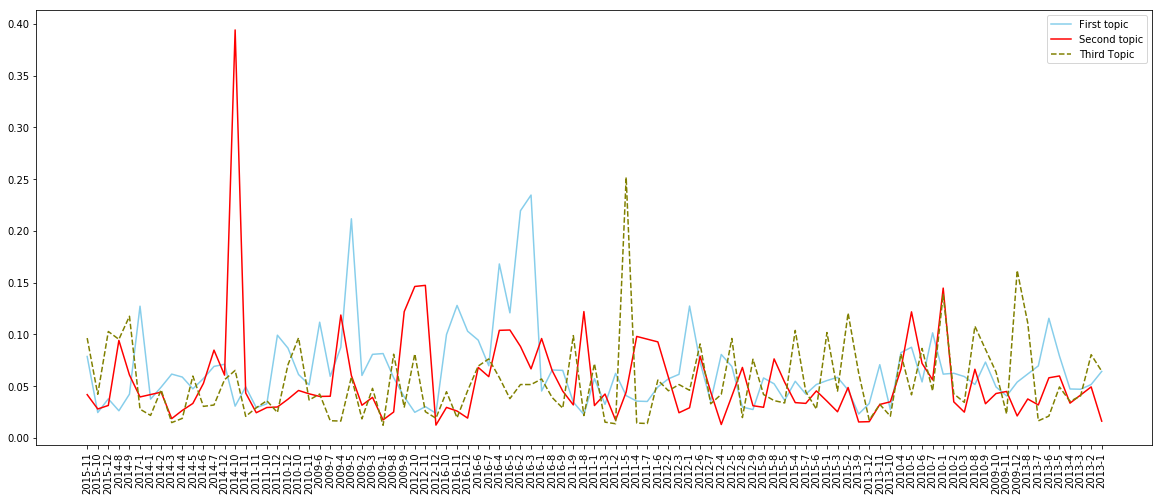

In [23]:
plt.figure(figsize=(20,8))
plt.plot( 'x', 'y', data=graph_1, marker='', color='skyblue',label = "First topic")
plt.plot( 'x', 'y', data=graph_2, marker='', color='red', label = "Second topic")
plt.plot( 'x', 'y', data=graph_3, marker='', color='olive',  linestyle='dashed', label="Third Topic")
plt.xticks(rotation=90)
plt.legend()

### LSI (Latent Semantic Indexing)

This is a useful topic modeling algorithm in that it can rank topics by itself. Thus it outputs topics in a ranked order.

### Parameter tuning for LSI

This is a useful topic modeling algorithm in that it can rank topics by itself. Thus it outputs topics in a ranked order. LSI examines the words and looks for how they are related to each other. For example, whether they are similar words, e.g. car, automobile and auto , they are kind of something else, e.g. car and vehicle, or they are part of a larger concept, e.g. engine and car.  In practice, LSI is much faster to train than LDA, but has lower accuracy.

In [24]:

# number of topics were tried to find the optimal number of topics

num_topic = [12, 15, 17, 19 , 21, 23, 35]
cohere_list_lsi = []
for i in num_topic:
    cur_lsi = gensim.models.lsimodel.LsiModel(corpus=raw_corpus2, id2word=dictionary, num_topics=i)
    cm = CoherenceModel(model=cur_lsi, texts=descriptions, dictionary=dictionary, coherence='c_v')
    cohere_list_lsi.append(cm.get_coherence())

cohere_list_lsi

[0.3283308309722896,
 0.30200756184639255,
 0.2941117261946232,
 0.28440437041763145,
 0.29939892123286554,
 0.2818326222159991,
 0.26408407892954294]

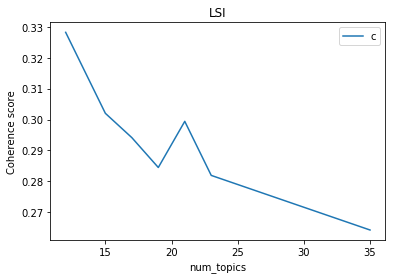

In [25]:
plt.plot(num_topic, cohere_list_lsi)
plt.title("LSI")
plt.xlabel("num_topics")
plt.ylabel("Coherence score")
plt.legend(("c_v"), loc='best')
plt.show()

In [26]:
lsi = gensim.models.lsimodel.LsiModel(corpus=raw_corpus2, id2word=dictionary, num_topics=12)


In [27]:
# To print the result for each topic

sitopics = lsi.print_topics(23)

output = ""

for j in range(0,len(sitopics)):
    output = output+ ", " + str(j)
    for i in range(0, len(lsi.show_topic(j))) : 
        output = output + ", "+ str(lsi.show_topic(j)[i] [0])
output

', 0, state, make, peopl, know, unit, talk, work, take, us, becaus, 1, unit, state, secur, tax, countri, job, look, militari, cut, isil, 2, republican, hous, congress, issu, senat, us, meet, discuss, american, democrat, 3, tax, congress, health, cut, peopl, know, care, look, american, republican, 4, iran, militari, agreement, forc, nuclear, republican, american, senat, meet, iraq, 5, iran, peopl, hous, nuclear, countri, agreement, tax, white, year, american, 6, care, insur, afford, health, senat, iran, peopl, forc, becaus, look, 7, iran, agreement, issu, nuclear, health, care, action, isil, cuban, budget, 8, senat, care, administr, republican, insur, health, meet, job, tax, afford, 9, syria, russia, hous, cuban, russian, secur, assad, weapon, govern, cuba, 10, american, iran, russia, budget, secretari, tax, unit, immigr, peopl, nuclear, 11, tax, cuban, congress, govern, secur, peopl, cuba, budget, white, made'